Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Ying Zhang"
COLLABORATORS = ""

---

# Exercise 03 - Due Friday, September 30 at 12pm


**Objectives**:  Gain experience loading a CSV dataset into a database and using SQL to explore its contents.  Write and execute a number of SQL queries using common syntax and functions.

**Grading criteria**: The tasks should all be completed, and questions should all be answered with SQL queries in the space provided, unless a text answer is requested.  Results should be correct, according to the embedded tests.  The notebook itself should be completely reproducible; from start to finish, another person should be able to use the same code to obtain the same results as yours.

**Deadline**: Friday, September 30, 12pm.  Submit your notebook to Blackboard and push it to your GitHub repository.

In this notebook we'll download a clean CSV dataset from data.gov, load it into a SQLite database, and perform a series of queries to answer several questions.  For each problem, write and execute queries that provides the answer in the cells provided, with your SQL queries in the places marked.  For each problem after executing your query, immediately execute the following test cell.  If the tests complete without error, you have completed that question successfully.  If errors arise, you might be missing something.  **Do not change the tests**, just execute them as they are, and update or refine your query until the tests pass.  

For this assignment, you need not add narrative description to most of your queries (except where explicitly noted), although you may do so if something you see in the data prompts you.  If you do, add new text cells and use Markdown formatting.

**Suggestion**: if you have worked through the [Software Carpentry SQL lessons](http://swcarpentry.github.io/sql-novice-survey/) and have run through the last two lecture notes notebooks, this should all be fairly easy.  If you have done neither, do them now, before you begin.

## Setup - obtain data and create database

The [Connecticut DMV Boating Registrations](http://catalog.data.gov/dataset/dmv-boating-registrations-2008-to-2014) dataset comprises several years of summary records.  It is available from data.gov.

First we download the dataset (*note*: it might take several seconds):

In [2]:
!wget --quiet -O boating.csv "https://data.ct.gov/api/views/mrb6-7ee5/rows.csv?accessType=DOWNLOAD"

Verify that it's what we think it is on the commandline:

In [3]:
!head boating.csv | csvlook

|--------------+-----------------------------+---------------|
|  Fiscal Year | Type of Transactions        | No .of Boats  |
|--------------+-----------------------------+---------------|
|  2008        | BOAT CHANGE OF TYPE         | 59            |
|  2009        | BOAT CHANGE OF TYPE         | 50            |
|  2010        | BOAT CHANGE OF TYPE         | 21            |
|  2011        | BOAT CHANGE OF TYPE         | 41            |
|  2012        | BOAT CHANGE OF TYPE         | 16            |
|  2013        | BOAT CHANGE OF TYPE         | 27            |
|  2014        | BOAT CHANGE OF TYPE         | 54            |
|  2008        | BOAT RECORD XFER NO PROBATE | 6             |
|  2009        | BOAT RECORD XFER NO PROBATE | 12            |
|--------------+-----------------------------+---------------|


Looks right.  How many records are there?

In [4]:
!wc -l boating.csv

     145 boating.csv


So that should be 145, counting the header.  And the basic stats:

In [5]:
!csvstat boating.csv

  1. Fiscal Year
	<class 'int'>
	Nulls: False
	Min: 2008
	Max: 2014
	Sum: 289578
	Mean: 2010.9583333333333
	Median: 2011.0
	Standard Deviation: 1.9960899278339177
	Unique values: 7
	5 most frequent values:
		2008:	21
		2010:	21
		2009:	21
		2011:	21
		2013:	20
  2. Type of Transactions
	<class 'str'>
	Nulls: False
	Unique values: 21
	5 most frequent values:
		BOAT REG, CANOE:	7
		BOAT REG, COMM FISHING:	7
		BOAT REG, NON-PROFIT:	7
		BOAT, REMAINDER FEE:	7
		BOAT REG, NEW:	7
	Max length: 32
  3. No .of Boats
	<class 'int'>
	Nulls: False
	Min: 0
	Max: 95270
	Sum: 767584
	Mean: 5330.444444444444
	Median: 43.5
	Standard Deviation: 19683.78413284855
	Unique values: 96
	5 most frequent values:
		2:	9
		19:	4
		21:	4
		0:	4
		1:	4

Row count: 144


Looks about right!  

Note, though, that the column names have spaces, punctuation, and Upper Cased Names.  That's annoying!  First let's rename the header line.

In [6]:
!mv boating.csv boating-orig.csv

Okay, using output redirection and `tail` we can write a new header line.

In [7]:
!echo "year,tx_type,num" > boating.csv

In [8]:
!tail -n +2 boating-orig.csv >> boating.csv

In [9]:
!head boating.csv | csvlook

|-------+-----------------------------+------|
|  year | tx_type                     | num  |
|-------+-----------------------------+------|
|  2008 | BOAT CHANGE OF TYPE         | 59   |
|  2009 | BOAT CHANGE OF TYPE         | 50   |
|  2010 | BOAT CHANGE OF TYPE         | 21   |
|  2011 | BOAT CHANGE OF TYPE         | 41   |
|  2012 | BOAT CHANGE OF TYPE         | 16   |
|  2013 | BOAT CHANGE OF TYPE         | 27   |
|  2014 | BOAT CHANGE OF TYPE         | 54   |
|  2008 | BOAT RECORD XFER NO PROBATE | 6    |
|  2009 | BOAT RECORD XFER NO PROBATE | 12   |
|-------+-----------------------------+------|


Much easier to work with now.

Next we convert the updated csv file into a SQLite database using CSVkit.

In [10]:
!csvsql --db sqlite:///boating.db --insert boating.csv

(sqlite3.OperationalError) table boating already exists [SQL: '\nCREATE TABLE boating (\n\tyear INTEGER NOT NULL, \n\ttx_type VARCHAR(32) NOT NULL, \n\tnum INTEGER NOT NULL\n)\n\n']


To work with it, we'll need the ipython-sql extension loaded, and then we'll need to connect to the db.

In [11]:
%load_ext sql

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


**Note** if you see a pink box above with six lines of "ShimWarning" and "UserWarning", don't panic.  This is just a warning message from the `ipython-sql` package.  You are good to go.

In [12]:
%sql sqlite:///boating.db

'Connected: None@boating.db'

In [13]:
%%sql
SELECT COUNT(*)
FROM boating;

Done.


COUNT(*)
144


Looks like the same number of rows!  We're good to go.

## Basic queries

In the following queries, we'll do some basic exploration of the data.  Let's first see what a few records look like.

In [14]:
%%sql
SELECT *
FROM boating
LIMIT 10;

Done.


year,tx_type,num
2008,BOAT CHANGE OF TYPE,59
2009,BOAT CHANGE OF TYPE,50
2010,BOAT CHANGE OF TYPE,21
2011,BOAT CHANGE OF TYPE,41
2012,BOAT CHANGE OF TYPE,16
2013,BOAT CHANGE OF TYPE,27
2014,BOAT CHANGE OF TYPE,54
2008,BOAT RECORD XFER NO PROBATE,6
2009,BOAT RECORD XFER NO PROBATE,12
2010,BOAT RECORD XFER NO PROBATE,15


This should look familiar!

Let's look at just the "change" types.

In [15]:
%%sql
SELECT *
FROM boating
WHERE tx_type = "BOAT CHANGE OF TYPE";

Done.


year,tx_type,num
2008,BOAT CHANGE OF TYPE,59
2009,BOAT CHANGE OF TYPE,50
2010,BOAT CHANGE OF TYPE,21
2011,BOAT CHANGE OF TYPE,41
2012,BOAT CHANGE OF TYPE,16
2013,BOAT CHANGE OF TYPE,27
2014,BOAT CHANGE OF TYPE,54


How many is that, and which year had the most?

In [16]:
%%sql
SELECT COUNT(*)
FROM boating
WHERE tx_type = "BOAT CHANGE OF TYPE";

Done.


COUNT(*)
7


Which year had the most of these transactions?

In [17]:
%%sql
SELECT *
FROM boating
WHERE tx_type = "BOAT CHANGE OF TYPE"
ORDER BY num DESC;

Done.


year,tx_type,num
2008,BOAT CHANGE OF TYPE,59
2014,BOAT CHANGE OF TYPE,54
2009,BOAT CHANGE OF TYPE,50
2011,BOAT CHANGE OF TYPE,41
2013,BOAT CHANGE OF TYPE,27
2010,BOAT CHANGE OF TYPE,21
2012,BOAT CHANGE OF TYPE,16


...alright, your turn.

### Question 1

Use `DISTINCT` to determine the unique set of years in this dataset.

In [18]:
%%sql
SELECT DISTINCT year
FROM boating;

Done.


year
2008
2009
2010
2011
2012
2013
2014


In [19]:
df = _.DataFrame()
for y in [2008, 2009, 2010, 2011, 2012, 2013, 2014]:
    assert y in df.year.values
assert len(df) == 7

### Question 2

Use `DISTINCT` to determine the unique set of transaction types in this dataset.

In [20]:
%%sql
SELECT DISTINCT tx_type 
FROM boating;

Done.


tx_type
BOAT CHANGE OF TYPE
BOAT RECORD XFER NO PROBATE
BOAT REG ST OF CONNECTICUT
"BOAT REG, CANOE"
"BOAT REG, COMM FISHING"
"BOAT REG, EDUCATIONAL"
"BOAT REG, NEW"
"BOAT REG, NON-PROFIT"
"BOAT REG, PONTOON"
"BOAT, DUPLICATE REGISTRATION"


In [21]:
df = _.DataFrame()
assert len(df) == 21
for tx_type in ["BOAT, DUPLICATE REGISTRATION", "REN BOAT PONTOON", "BOAT REG, CANOE"]:
    assert tx_type in df.tx_type.values

### Question 3

Use `GROUP BY` to determine the overall number of transactions (across all types) per year.

In [22]:
%%sql
SELECT year, COUNT(tx_type) AS count
From boating
GROUP BY year;

Done.


year,count
2008,21
2009,21
2010,21
2011,21
2012,20
2013,20
2014,20


In [23]:
df = _.DataFrame()
df.rename(columns=lambda x: "year" if x == "year" else "count", inplace=True)
assert (df.loc[df['year'] == 2009]['count'] == 21).all()
assert (df.loc[df['year'] == 2013]['count'] == 20).all()

### Question 4

Use `SUM` and `GROUP BY` to determine the overall number of transactions (across all years) per type.

In [24]:
%%sql
SELECT tx_type, SUM(num) AS sum
FROM boating
GROUP BY tx_type;

Done.


tx_type,sum
BOAT CHANGE OF TYPE,268
BOAT RECORD XFER NO PROBATE,105
BOAT REG ST OF CONNECTICUT,159
"BOAT REG, CANOE",1129
"BOAT REG, COMM FISHING",114
"BOAT REG, EDUCATIONAL",15
"BOAT REG, NEW",86821
"BOAT REG, NON-PROFIT",106
"BOAT REG, PONTOON",2241
"BOAT, DUPLICATE REGISTRATION",2390


In [25]:
df = _.DataFrame()
df.rename(columns=lambda x: "tx_type" if x == "tx_type" else "sum", inplace=True)
assert (df.loc[df['tx_type'] == "BOAT REG, CANOE"]['sum'] == 1129).all()
assert (df.loc[df['tx_type'] == "REN BOAT REGISTRATION"]['sum'] == 640790).all()

### Question 5

Use `ORDER BY` and `LIMIT` to determine the top five types of transactions overall.

In [26]:
%%sql
SELECT tx_type, SUM(num) AS sum_num
FROM boating
GROUP BY tx_type
ORDER BY sum_num DESC
LIMIT 0,5;

Done.


tx_type,sum_num
REN BOAT REGISTRATION,640790
"BOAT REG, NEW",86821
REN BOAT PONTOON,15556
RENEW BOAT CANOE,14551
"BOAT, DUPLICATE REGISTRATION",2390


In [27]:
df = _.DataFrame()
df.rename(columns=lambda x: "tx_type" if x == "tx_type" else "sum_num", inplace=True)
assert len(df) == 5
assert (df.loc[df['tx_type'] == "REN BOAT PONTOON"]['sum_num'] == 15556).all()
assert (df.loc[df['tx_type'] == "REN BOAT REGISTRATION"]['sum_num'] == 640790).all()
assert df['sum_num'].max() == 640790
assert df['sum_num'].min() == 2390

### Question 6

Using `ORDER BY` and `LIMIT` again, what were the top five types of transactions in 2010?

In [28]:
%%sql
SELECT tx_type, SUM(num) AS num
FROM boating
WHERE year = "2010"
GROUP BY tx_type
ORDER BY num DESC
LIMIT 0,5;

Done.


tx_type,num
REN BOAT REGISTRATION,94005
"BOAT REG, NEW",12569
RENEW BOAT CANOE,2157
REN BOAT PONTOON,2118
"BOAT, DUPLICATE REGISTRATION",555


In [29]:
df = _.DataFrame()
assert len(df) == 5
assert (df.loc[df['tx_type'] == "REN BOAT PONTOON"]['num'] == 2118).all()
assert (df.loc[df['tx_type'] == "BOAT REG, NEW"]['num'] == 12569).all()
assert df['num'].max() == 94005
assert df['num'].min() == 555

### Question 7

Use a wildcard search to determine how many transactions in 2012 were renewals.

In [30]:
%%sql
SELECT COUNT(tx_type) 
FROM boating
WHERE tx_type LIKE 'RENEW%'
AND year = '2012';

Done.


COUNT(tx_type)
7


In [31]:
df = _.DataFrame()
assert df.values[0][0] in [7, 9]

### Question 8

How many transactions overall involve canoes?

In [32]:
%%sql
SELECT count(tx_type) 
FROM boating
WHERE tx_type LIKE '%CANOE';

Done.


count(tx_type)
14


In [33]:
df = _.DataFrame()
assert df.values[0][0] == 14

### Question 9



How many transactions in 2011 involved a new registration (as opposed to a renewal or change of type)?

In [34]:
%%sql
SELECT SUM(num) 
FROM boating
WHERE tx_type LIKE '%NEW'
AND year = '2011';

Done.


SUM(num)
12071


In [35]:
df = _.DataFrame()
assert df.values[0][0] in [12071, 14466]

### Question 10

How do the transaction trends over time involving pontoons compare to overall boating transaction activity?  Discuss as appropriate, adding Markdown cells for your discussion after your exploratory queries.

In [36]:
%%sql
SELECT year, SUM(num) AS overall, 
       SUM(CASE WHEN tx_type LIKE '%PONTOON%' THEN num END) AS pontoon
FROM boating
GROUP BY year;

Done.


year,overall,pontoon
2008,115520,2283
2009,113198,2350
2010,112337,2410
2011,109962,2495
2012,107608,2658
2013,105375,2781
2014,103584,2820


TREND: 
From 2008 to 2014, the overall boating transaction is decreacing. 
However, the transaction involving pontoons is increasing during 2008 and 2014.

### Bonus (10 points)

Make a plot (inline, here, using python) that demonstrates one or more overall trends in boat registrations in Connecticut, drawing data directly from the database.

      Connecticut
2008           19
2009            3
2010           19
2011           27
2012           48
2013           21
2014           22


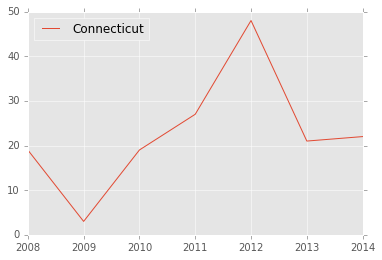

In [46]:
import sqlite3
query = "SELECT year, SUM(num) AS Connecticut \
         FROM boating \
         WHERE tx_type LIKE '%CONNECTICUT%' \
         GROUP BY year;"

connection = sqlite3.connect("boating.db")
cursor = connection.cursor()
cursor.execute(query)
results = cursor.fetchall()
cursor.close()
connection.close()

import pandas as pd
data = []
for i in results:
    data.append([j for j in i])
    
df = pd.DataFrame(data)

df.columns = [ 'year' , 'Connecticut' ]
del df["year"]
df.index = [str(y) for y in range(2008,2015)]
print (df)

%matplotlib inline
import matplotlib               
matplotlib.style.use('ggplot') 
df.plot.line()

In [16]:
%%sql
SELECT year, SUM(num) AS Connecticut 
FROM boating 
WHERE tx_type LIKE '%CONNECTICUT%' 
GROUP BY year;


Done.


year,Connecticut
2008,19
2009,3
2010,19
2011,27
2012,48
2013,21
2014,22


<Container object of 7 artists>

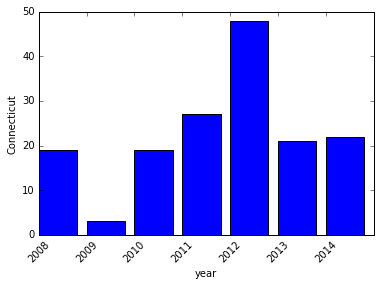

In [18]:
%matplotlib inline
import matplotlib   
result = _
result.bar()